In [1]:
from matplotlib.pyplot import *
import numpy as np
from matplotlib import *
import h5py
from matplotlib import cm
from tqdm import tqdm
import pandas as pd
import sklearn
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter

In [2]:
def read_data_map(file,remove_baseline=False):

    hf = h5py.File(file + '.h5', 'r')
    sample = file.split("\\")[-1]
    keys = [key for key in hf.keys()]
    sample = keys[0].split(' ')[-1]

    spectrums = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['Shot_0']['Pro']))) for i in range(0, #Pro sem baseline, raw com baseline
                                                        len(list(hf['Sample_ID: ' + sample])))])
    positions = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['position']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    wavelengths = np.array(hf['System properties']['wavelengths'])
    
    new_specs = []
        
    unique_x = np.unique(positions[:,0])
    unique_y = np.unique(positions[:,1])
    
    nx = len(unique_x)
    ny = len(unique_y)
    indexes = np.lexsort((positions[:,0],positions[:,1]))
    spectrums = spectrums[indexes,:]
    spectrums = np.array(spectrums.reshape((ny,nx,-1)))
    print(spectrums.shape)
    positions = np.array(positions[indexes])
    
    hf.close()
    return spectrums, wavelengths, positions, unique_x, unique_y

In [3]:
find_index = lambda wavelenghts, w : np.argmin(np.abs(wavelenghts-w))

In [4]:
file = r"C:/Users/tomas/Desktop/Tomás/LIBS/FFT_multi/example_map"

spectrum, wavelengths, positions, unique_x, unique_y = read_data_map(file)

(170, 120, 16384)


In [5]:
spe = spectrum.reshape(spectrum.shape[0]*spectrum.shape[1], -1)
norm = np.array([gaussian_filter(spe[i, :]/np.sum(spe[i, :]), sigma = 0) for i in range(0, spe.shape[0])]).reshape(spectrum.shape)

In [6]:
scaled_pro = np.array([ gaussian_filter((norm[:, :, wv] - norm[:, :, wv].min())/(norm[:, :, wv].max() - norm[ :, :, wv].min()), sigma = 0)
                        for wv in range(norm.shape[-1])])

In [7]:
def gauss(x, sigma, val):
    return np.exp( - (x - val)**2 / (2 * sigma ** 2))

## Well-Exposedness

In [8]:
from scipy.ndimage import convolve

kernel = (1.0/256)*np.array([[1, 4, 6, 4, 1],[4, 16, 24, 16, 4],[6, 24, 36, 24, 6], [4, 16, 24, 16, 4],[1, 4, 6, 4, 1]])

def add_padding(data, x_pad, y_pad):
    return np.pad(data, ((0, 0), (x_pad, x_pad), (y_pad, y_pad)), mode = 'mean')

def downscale(image):
    image_blur = convolve(image, kernel, mode = 'constant')
    return image_blur[::2, ::2]  

def upscale(image):
    image_up = np.zeros((2*image.shape[0], 2*image.shape[1]))
    image_up[::2, ::2] = image
    return convolve(image_up, 4*kernel, mode = 'constant')

def laplacian_pyramid(image, layers):
    laplace_pyra = []
    for energy in range(image.shape[0]):
        im1 = image[energy]
        lap_pyra = []
        for layer in range(layers):
            down = downscale(im1)
            up = upscale(down)
            lap_pyra.append(im1 - up)
            im1 = down
        lap_pyra.append(down)
        laplace_pyra.append(lap_pyra)
    return np.array(laplace_pyra, dtype = object)

def gaussian_pyramid(mask, layers):
    gaussian_pyra = []
    for energy in range(mask.shape[0]):
        im1 = mask[energy]
        gauss_pyra = [im1]
        for layer in range(0, layers):
            im1 = downscale(im1)
            gauss_pyra.append(im1)
        gaussian_pyra.append(gauss_pyra)
    return np.array(gaussian_pyra, dtype = object)

def final_pyramid(L, G):
    laplacian_final = []
    for i in range(L.shape[1]):
        laplacian_final.append((L[0, i]*G[0, i] + L[1, i]*G[1, i] + L[2, i]*G[2, i]))
    return np.array(laplacian_final, dtype = object)

def get_image(final_pyramid):
    rev_pyramid = final_pyramid[::-1]
    im = rev_pyramid[0]
    for i in range(1, len(rev_pyramid)):
        im = upscale(im) + rev_pyramid[i]
    return im

# Between Element Lines

In [9]:
# Li = [610.223, 460.236, 812.562]
# Si = [288.167, 251.590, 252.817]
# Na = [568.766, 588.95, 819.40]
# Al = [309.25, 308.169, 257.481]
Li = [610.223, 460.236, 812.562]
Si = [288.167, 251.590, 252.817]
K = [769.811, 766.398, 693.80]
Na = [568.766, 588.95, 819.40]
Al = [309.25, 308.169, 257.481]

from scipy.ndimage import gaussian_filter

energy = 0
sig = 0

Li_lines = np.array([gaussian_filter(norm[:, :, find_index(wavelengths, Li[i])], sigma = sig) for i in range(len(Li))])
Si_lines = np.array([gaussian_filter(norm[:, :, find_index(wavelengths, Si[i])], sigma = sig) for i in range(len(Si))])
K_lines  = np.array([gaussian_filter(norm[:, :, find_index(wavelengths,  K[i])], sigma = sig) for i in range(len(K ))])
Na_lines = np.array([gaussian_filter(norm[:, :, find_index(wavelengths, Na[i])], sigma = sig) for i in range(len(Na))])
Al_lines = np.array([gaussian_filter(norm[:, :, find_index(wavelengths, Al[i])], sigma = sig) for i in range(len(Al))])

lines = np.stack([Li_lines, Si_lines, K_lines, Na_lines, Al_lines], axis = 3)

In [46]:
scaled_pro = []
for i in range(0, lines.shape[0]):
    # min_max_scaled = np.array([ (pro_data_sum[i, :, :, wv] - pro_data_sum[i].min())/(pro_data_sum[i].max() - pro_data_sum[i].min()) for wv in range(pro_data_sum.shape[-1])])
    min_max_scaled = np.array([ gaussian_filter((lines[i, :, :, wv] - lines[i, :, :, wv].min())/(lines[i, :, :, wv].max() - lines[i, :, :, wv].min()), sigma =0)
                               for wv in range(lines.shape[-1])])
    scaled_pro.append(min_max_scaled)

scaled_pro = np.array(scaled_pro)

In [47]:
w_exposedness = gauss(scaled_pro, 0.2, 0.5)
weights_norm = w_exposedness.copy()
sum = np.sum(w_exposedness, axis = 0)
weights_norm = w_exposedness/sum
            
weights_norm = np.array(weights_norm)

In [48]:
new_data1 = np.zeros(scaled_pro.shape[1:])
n_layers = 4

x_padding = 3
y_padding = 4

for j in tqdm(range(weights_norm.shape[1])):
    image_p = add_padding(scaled_pro[:, j], x_padding, y_padding)
    L = laplacian_pyramid(image_p, layers = n_layers)
    weights_p = add_padding(weights_norm[:, j], x_padding, y_padding)
    G = gaussian_pyramid(weights_p, layers = n_layers)
    final_pyra = final_pyramid(L, G)
    pyra_image = get_image(final_pyra)
    new_data1[j, :, :] = pyra_image[x_padding:pyra_image.shape[0]-x_padding, y_padding:pyra_image.shape[1]-y_padding]

100%|██████████| 5/5 [00:00<00:00, 70.90it/s]


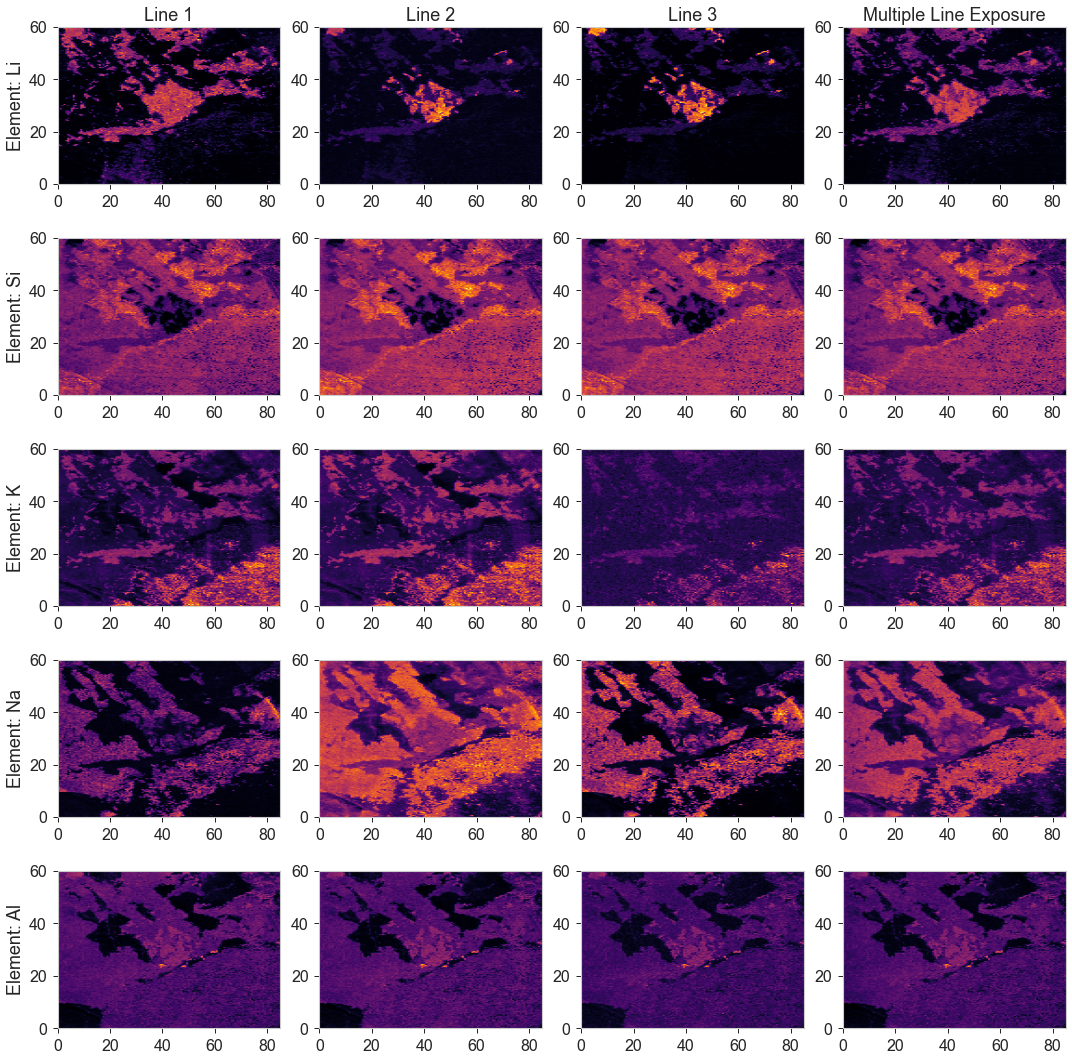

In [49]:
%matplotlib inline
fig, ax = subplots(5, 4, figsize = (15, 15))

elements = ['Li', 'Si', 'K', 'Na', 'Al']

for w in range(len(elements)):
    maps = scaled_pro[:, w]
    
    axs = ax[w, 0]
    if w == 0:
        axs.set_title('Line 1', fontsize = 18)
    # if w == 3:
        # axs.set_xlabel('x (mm)', fontsize = 18)
    axs.imshow(maps[0], extent = (0, 85, 0, 60), cmap = 'inferno', vmin = 0, vmax = 1)
    # axs.set_ylabel(f'Element: {elements[w]}')
    axs.set_ylabel(f'Element: {elements[w]}', fontsize = 18)
    axs.grid(False)
    axs.set_xticks([0, 20, 40, 60, 80])
    axs.set_yticks([0, 20, 40, 60])
    axs.set_xticklabels([0, 20, 40, 60, 80], fontsize = 16)
    axs.set_yticklabels([0, 20, 40, 60], fontsize = 16)
    axs.tick_params(
                bottom=True, top=False,
                left=True, right=False, length = 5, width = 1)
    

    axs = ax[w, 1]
    if w == 0:
        axs.set_title('Line 2', fontsize = 18)
    # if w == 3:
        # axs.set_xlabel('x (mm)', fontsize = 18)
    axs.imshow(maps[1], extent = (0, 85, 0, 60), cmap = 'inferno', vmin = 0, vmax = 1)
    axs.grid(False)
    axs.set_xticks([0, 20, 40, 60, 80])
    axs.set_yticks([0, 20, 40, 60])
    axs.set_xticklabels([0, 20, 40, 60, 80], fontsize = 16)
    axs.set_yticklabels([0, 20, 40, 60], fontsize = 16)
    axs.tick_params(
                bottom=True, top=False,
                left=True, right=False, length = 5, width = 1)

    axs = ax[w, 2]
    if w == 0:
        axs.set_title('Line 3', fontsize = 18)
    # if w == 3:
        # axs.set_xlabel('x (mm)', fontsize = 18)
    axs.imshow(maps[2], extent = (0, 85, 0, 60), cmap = 'inferno', vmin = 0, vmax = 1)
    axs.grid(False)
    axs.set_xticks([0, 20, 40, 60, 80])
    axs.set_yticks([0, 20, 40, 60])
    axs.set_xticklabels([0, 20, 40, 60, 80], fontsize = 16)
    axs.set_yticklabels([0, 20, 40, 60], fontsize = 16)
    axs.tick_params(
                bottom=True, top=False,
                left=True, right=False, length = 5, width = 1)

    axs = ax[w, 3]
    if w == 0:
        axs.set_title('Multiple Line Exposure', fontsize = 18)
    # if w == 3:
        # axs.set_xlabel('x (mm)', fontsize = 18)
    axs.imshow(new_data1[w], extent = (0, 85, 0, 60), cmap = 'inferno', vmin = 0, vmax = 1)
    axs.grid(False)
    axs.set_xticks([0, 20, 40, 60, 80])
    axs.set_yticks([0, 20, 40, 60])
    axs.set_xticklabels([0, 20, 40, 60, 80], fontsize = 16)
    axs.set_yticklabels([0, 20, 40, 60], fontsize = 16)
    axs.tick_params(
                bottom=True, top=False,
                left=True, right=False, length = 5, width = 1)

fig.tight_layout()
# fig.savefig('MLE_libs.jpg', dpi = 300)

In [54]:
from sklearn.cluster import KMeans

init = np.array([[1, 1, 0, 0, 1],
                 [0, 1, 0, 1, 1],
                 [0, 1, 0, 0, 0],
                 [0, 1, 1, 0, 1]])

model = KMeans(n_clusters = 4, init = init*0.5)
data = new_data1.reshape(new_data1.shape[0], -1).T
labels = model.fit_predict(data)

c:\Users\tomas\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


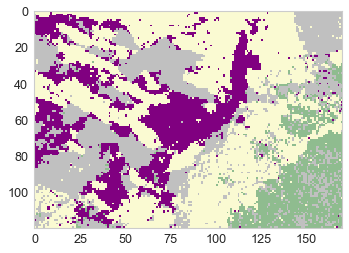

In [58]:
subplots()

nx, ny = 170, 120
colors = ['Purple', 'lightgoldenrodyellow', 'silver','darkseagreen', 'ghostwhite']
cmp_libs = ListedColormap(colors[:4])

imshow(labels.reshape(nx, ny).T[::, ::], interpolation = 'nearest', cmap = cmp_libs)
grid()

In [82]:
lines_t = np.transpose(scaled_pro, axes = (2, 3, 1, 0))
lines_t = lines_t.reshape(lines_t.shape[0]*lines_t.shape[1], -1)

In [83]:
from sklearn.cluster import KMeans

init = np.array([[1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                 [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
model = KMeans(n_clusters = 5, init = init)
labels1 = model.fit_predict(lines_t)

c:\Users\tomas\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


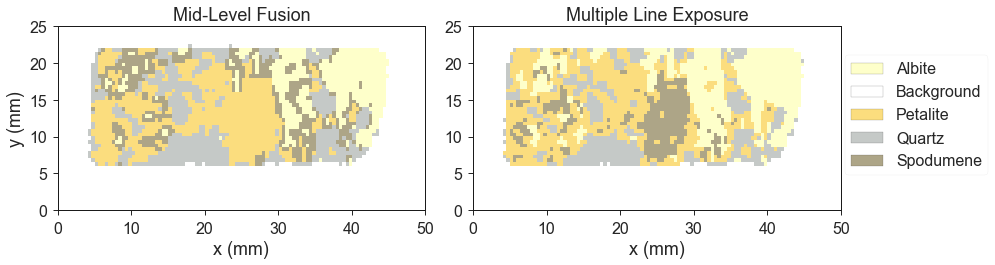

In [26]:
fig, ax = subplots(1, 2, figsize = (12, 6))

matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['axes.edgecolor'] = '0.1'

axs = ax[0]
axs.imshow(labels1.reshape(50, 110)[::, ::-1], cmap = cmp_init, interpolation = 'nearest', extent = (0, 50, 0, 25))
axs.set_xlabel('x (mm)', fontsize = 18)
axs.set_ylabel('y (mm)', fontsize = 18)
axs.set_title('Mid-Level Fusion', fontsize = 18)
axs.set_xticks([0, 10, 20, 30, 40, 50])
axs.set_yticks([0, 5, 10, 15, 20, 25])
axs.set_xticklabels([0, 10, 20, 30, 40, 50], fontsize = 16)
axs.set_yticklabels([0, 5, 10, 15, 20, 25], fontsize = 16)
axs.tick_params(
            bottom=True, top=False,
            left=True, right=False, length = 5, width = 1)
axs.grid()

axs = ax[1]
axs.imshow(labels.reshape(nx, ny)[::, ::-1], interpolation = 'nearest', cmap = cmp_init, extent = (0, 50, 0, 25))
axs.set_xlabel('x (mm)', fontsize = 18)
axs.set_title('Multiple Line Exposure', fontsize = 18)
axs.set_xticks([0, 10, 20, 30, 40, 50])
axs.set_yticks([0, 5, 10, 15, 20, 25])
axs.set_xticklabels([0, 10, 20, 30, 40, 50], fontsize = 16)
axs.set_yticklabels([0, 5, 10, 15, 20, 25], fontsize = 16)
axs.tick_params(
            bottom=True, top=False,
            left=True, right=False, length = 5, width = 1)

mineral = ['Albite', 'Background', 'Petalite', 'Quartz', 'Spodumene']
colors = ['xkcd:ecru', 'xkcd:white',  'xkcd:wheat' , 'xkcd:silver','xkcd:stone']

hls = []
for color, cluster in zip(colors, mineral):
    patch = mpatches.Patch(color = color, label = cluster, ec = 'k')
    hls.append(patch)
axs.grid()
fig.legend(handles = hls,loc = 'lower center',  bbox_to_anchor = (1.065, 0.35), ncol = 1, fontsize = 16)
fig.tight_layout()
# fig.savefig('libs_multi_fusion.jpg', dpi = 300, bbox_inches = 'tight')

In [87]:
cent_libs = model.cluster_centers_
cent_libs.shape

(5, 4)

In [27]:
from matplotlib import *
from matplotlib.pyplot import *

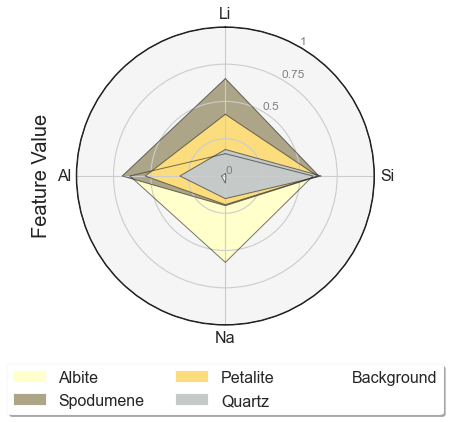

In [88]:
fig = figure(figsize = (10, 5))
G = GridSpec(1,1)
axs = fig.add_subplot(G[0],polar=True)

label = ['Petalite', 'Albite', 'Quartz', 'Spodumene', 'Background']
# colors = ['xkcd:wheat', 'xkcd:ecru', 'xkcd:silver','xkcd:stone', 'xkcd:white']
colors = ['xkcd:wheat', 'xkcd:ecru', 'xkcd:silver','xkcd:stone', 'xkcd:white']

N = 4
categories = elements

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

axs.set_theta_offset(np.pi / 2)
axs.set_theta_direction(-1)
axs.set_xticks(angles[:-1])
axs.set_xticklabels(categories,size=16)
axs.set_rlabel_position(30)
axs.set_yticks([0,0.25,0.5,0.75,1])
axs.set_yticklabels(["0","","0.5","0.75","1"], size=12,c='grey')
axs.set_ylim(0, top = 1)
iis = [1, 3, 0, 2, 4]

for i in iis:
    center = cent_libs[i]
    values = [center[j] for j in range(N)]
    values += values[:1]
    axs.plot(angles, values, color='k',lw=1,alpha=0.6,ls='-') #, label=minerals[i]
    axs.fill(angles, values, color=colors[i], alpha=1, label = label[i])

axs.yaxis.get_gridlines()[-1].set_color("k")
axs.yaxis.get_gridlines()[-1].set_linewidth(2)
axs.set_ylabel('Feature Value', fontsize = 20, c = 'k', labelpad = 25)

axs.set_facecolor("whitesmoke")
fig.set_facecolor("white")
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0),
          fancybox=True, shadow=True, ncol=3, fontsize = 16)
fig.tight_layout()
# fig.savefig('perceptual_graph_libs.jpg', dpi = 300, bbox_inches = 'tight')